# Predict the closing price, Model: SARIMAX, Stock Token: FPT, Train/Test/Validation/: 80/10/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 971.2
- MAE: 638.9265588532827
- MAPE: 0.84 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> FPT - 8 1 1
split = 2  # 8 1 1
stock = 0  # FPT

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1308,2024-05-27,133000,133500,130600,132800,5157800,FPT
1309,2024-05-28,134000,137000,133100,137000,4625300,FPT
1310,2024-05-29,137100,138200,134800,135700,5837600,FPT
1311,2024-05-30,133800,135000,131900,135000,7261300,FPT


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [6]:
df.reset_index(drop=True)
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [7]:
# Shape of the dataframe
df.shape

(1313, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,56251.291698,56880.086824
std,27151.082839,27473.981127
min,19080.000000,19190.000000
25%,28120.000000,28410.000000
50%,62770.000000,63470.000000
75%,70940.000000,71450.000000
max,136100.000000,138000.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

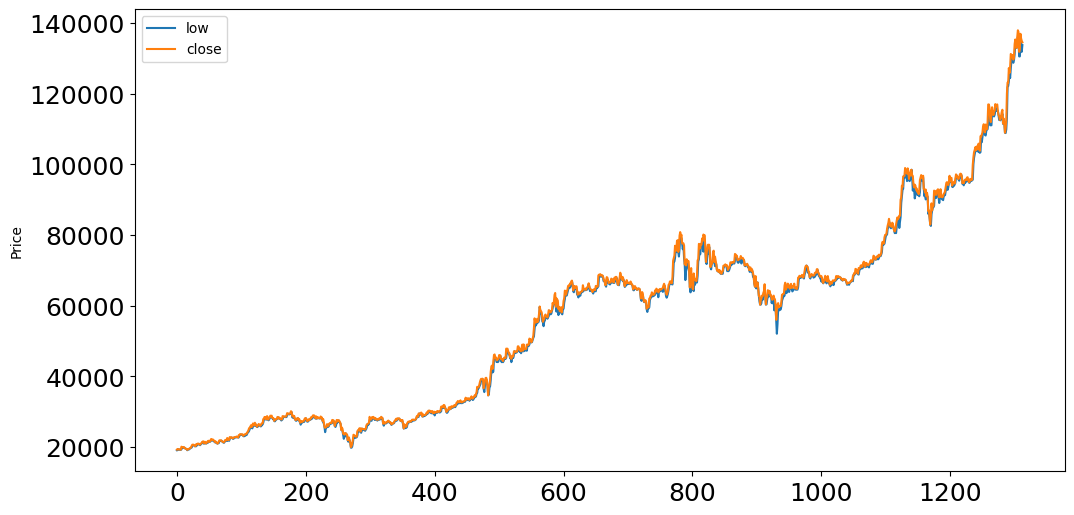

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(1.8386035496403486,
 0.9984225848793727,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 21624.1407585791)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.920
Failed to Reject Ho - Time Series is Non-Stationary


ADF Test on 'close' -> p-value: 0.902
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


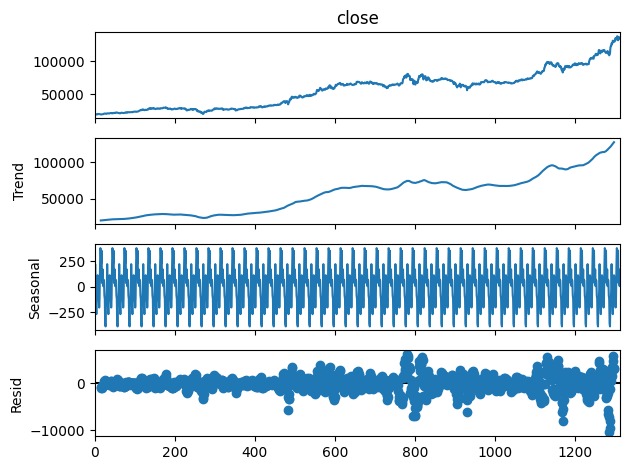

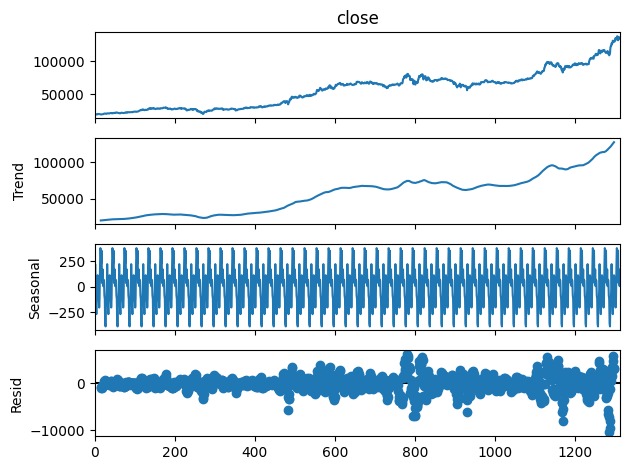

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-8.044223179266517,
 1.8126864685770498e-12,
 22,
 1026,
 {'1%': -3.4367396063176874,
  '5%': -2.8643611157329905,
  '10%': -2.5682720836420705},
 16884.10281027981)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

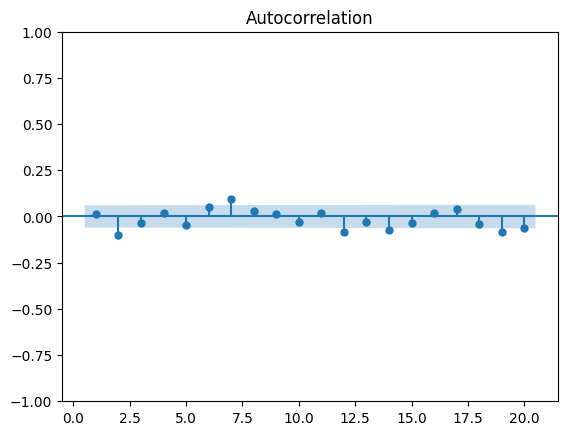

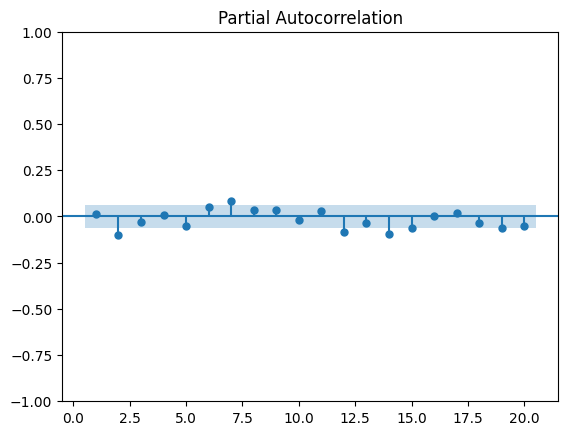

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=17263.793, Time=4.44 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=17270.079, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=17271.795, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=17271.608, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=17270.869, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=17267.412, Time=2.06 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=17267.503, Time=1.43 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=inf, Time=6.91 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=17269.675, Time=3.66 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=17267.582, Time=0.66 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=17267.853, Time=1.78 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=17268.218, Time=1.42 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=inf, Time=4.48 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=17268.580, Time=1.87 sec
 ARIMA(2,1,1)(1,0,1)[5] interce

In [23]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1050
Model:             SARIMAX(4, 1, 3)x(0, 0, [1], 5)   Log Likelihood               -8614.596
Date:                             Thu, 06 Jun 2024   AIC                          17247.193
Time:                                     22:28:23   BIC                          17291.793
Sample:                                          0   HQIC                         17264.105
                                            - 1050                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6580      0.048     13.702      0.000       0.564       0.752
ar.L2          0.6818      

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([68906.81956129, 68867.50123403, 69112.35160982, 69360.78064804,
       69604.34315159, 69828.71892848, 69344.83800698, 69099.56348061,
       69033.52803121, 70061.79431481, 70552.34336754, 70552.34336754,
       70703.28153761, 70703.28153761, 70703.28153761, 71269.29967538,
       71995.68961884, 71665.51237181, 71024.02514901, 71193.83059034,
       71108.92786968, 71665.51237181, 71505.14056611, 71108.92786968,
       70948.55606398, 71825.88417751, 71995.68961884, 72552.27412098,
       71995.68961884, 72071.15870388, 71910.78689818, 73033.38953808,
       73835.24856658, 73429.60223451, 73033.38953808, 73033.38953808,
       73184.32770815, 73854.11583783, 73099.42498748, 73288.09770007,
       73939.0185585 , 74033.35491479, 73939.0185585 , 74410.70033997,
       75061.6211984 , 77297.39284257, 76929.48105302, 77108.72012998,
       77297.39284257, 78325.65912617, 79259.58905348, 79627.50084303,
       79721.83719933, 81306.68798507, 81589.69705395, 82797.20241451,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([ 90472.11061012,  89574.33144058,  88168.29558123,  89680.83179378,
        90735.68696147,  89761.99101341,  89193.20737125,  89098.87101496,
        88910.19830237,  90042.2345779 ,  90230.90729049,  90230.90729049,
        91457.27992231,  92494.97984154,  92872.32526672,  91645.9526349 ,
        92306.30712896,  93344.00704819,  94004.36154225,  93910.02518595,
        93910.02518595,  93721.35247337,  92494.97984154,  92400.64348525,
        92872.32526672,  92777.98891043,  93155.3343356 ,  93532.67976078,
        95042.06146148,  95513.74324295,  94947.72510519,  94759.0523926 ,
        94381.70696742,  94098.69789854,  94853.3887489 ,  95136.39781778,
        95702.41595554,  95230.73417407,  93249.6706919 ,  93438.34340448,
        92872.32526672,  93627.01611707,  93438.34340448,  93721.35247337,
        93910.02518595,  94381.70696742,  94476.04332372,  94098.69789854,
        93627.01611707,  93532.67976078,  94004.36154225,  94004.36154225,
        94098.69789854,  

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[92427.90243233 92529.84897688 92595.22061308 92654.73727607
 92633.91831936 92754.28444169 92807.88108843 92864.24323957
 92920.60539071 92976.96754185 93033.32969299 93089.69184413
 93146.05399527 93202.41614641 93258.77829755 93315.14044869
 93371.50259983 93427.86475098 93484.22690212 93540.58905326
 93596.9512044  93653.31335554 93709.67550668 93766.03765782
 93822.39980896 93878.7619601  93935.12411124 93991.48626238
 94047.84841352 94104.21056466]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

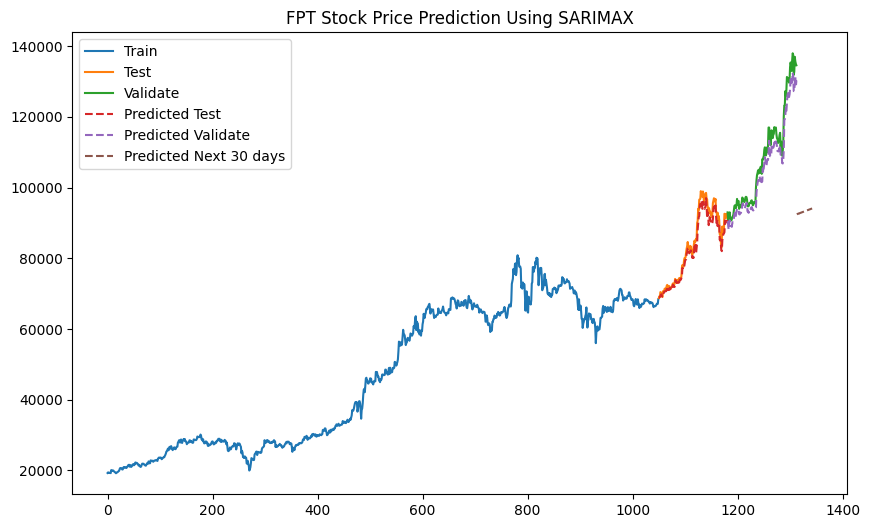

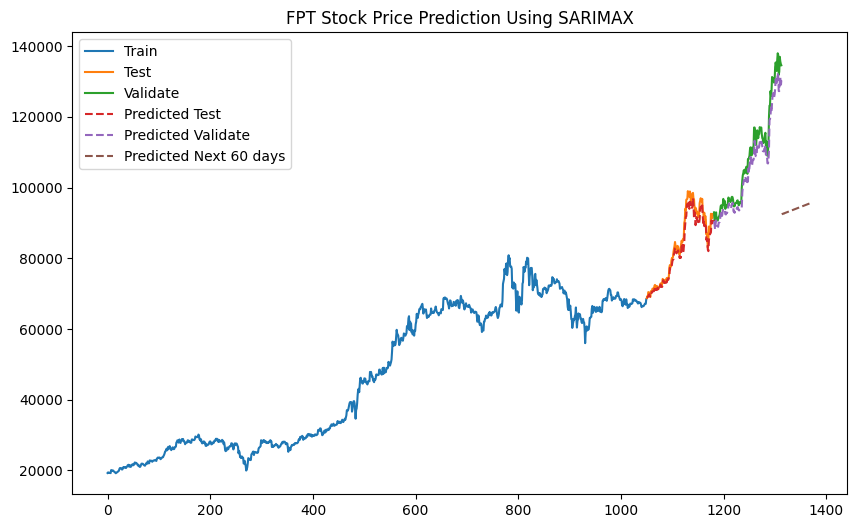

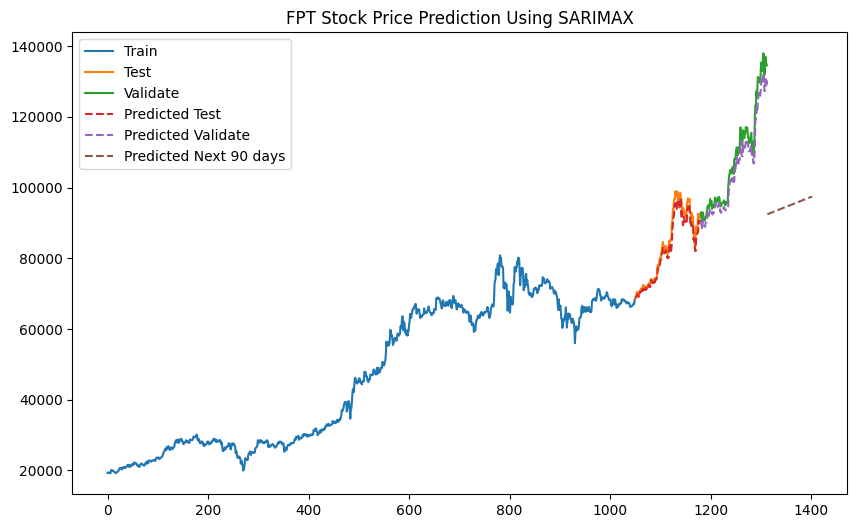

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 1995.529617610203
MAE on test data: 1544.1162867870405
MAPE on test data: 1.744666830494485 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 3486.9591817753994
MAE on validation data: 3120.190860997969
MAPE on validation data: 2.792426566612109 %
